# Download data

In [1]:
!mkdir data

A subdirectory or file data already exists.


In [2]:
!curl -L -o ./data/depression-reddit-cleaned.zip\
  https://www.kaggle.com/api/v1/datasets/download/infamouscoder/depression-reddit-cleaned

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  4  979k    4 50117    0     0  43286      0  0:00:23  0:00:01  0:00:22 43286
100  979k  100  979k    0     0   522k      0  0:00:01  0:00:01 --:--:-- 1301k


In [3]:
!curl -L -o ./data/Reddit_depression_dataset.csv\
    https://raw.githubusercontent.com/usmaann/Depression_Severity_Dataset/refs/heads/main/Reddit_depression_dataset.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1599k  100 1599k    0     0  1617k      0 --:--:-- --:--:-- --:--:-- 1620k


# Unzip data and clean `.zip` file

In [4]:
!unzip ./.data/depression-reddit-cleaned.zip -d ./
!rm ./data/depression-reddit-cleaned.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk 

from utilities.preprocessors import (
    remove_contractions,
    rem_non_alpha_num,
    partition_corpus,
    stem_corpus_words,
    lemmatize_corpus_words,
    strip_final_corpus,
    lower_words,
    flatten_series_of_lists,
    re_encode_sparse_labels,
    encode_features,
    normalize_train_cross,
    vectorize_sent)

from utilities.visualizers import (
    view_words,
    data_split_metric_values,
    view_value_frequency,
    multi_class_heatmap,
    view_metric_values, 
    view_label_freq,)

from utilities.feature_engineers import (
    # pre feature engineering
    count_capital_chars,
    count_capital_words,
    count_punctuations,
    count_sent,
    count_stopwords,

    # you can use this for X/twitter posts
    count_htags,
    count_mentions,
    
    # post feature engineering
    count_chars,
    count_words,
    count_unique_words)

from utilities.loaders import (
    split_into_train_test
)

# download stopwords and wordnet if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LARRY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LARRY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\LARRY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Prepare data

In [2]:
ddr_1 = pd.read_csv('./data/Reddit_depression_dataset.csv', )
ddr_1

text     label
0     He said he had not felt that way before, sugge...      mild
1     Hey there r/assistance, Not sure if this is th...   minimum
2     My mom then hit me with the newspaper and it s...   minimum
3     until i met my new boyfriend, he is amazing, h...      mild
4     October is Domestic Violence Awareness Month a...  moderate
...                                                 ...       ...
3548  i have horrible vivid nightmares every night. ...  moderate
3549  Also I can't think about both of them without ...  moderate
3550  Furthermore, I told him before we got really s...      mild
3551  Here's the link to my amazon wish list where t...   minimum
3552  How can I keep us protected? They have already...   minimum

[3553 rows x 2 columns]

In [3]:
ddr_2 = pd.read_csv('./data/depression_dataset_reddit_cleaned.csv')
ddr_2

clean_text  is_depression
0     we understand that most people who reply immed...              1
1     welcome to r depression s check in post a plac...              1
2     anyone else instead of sleeping more when depr...              1
3     i ve kind of stuffed around a lot in my life d...              1
4     sleep is my greatest and most comforting escap...              1
...                                                 ...            ...
7726                                       is that snow              0
7727                 moulin rouge mad me cry once again              0
7728  trying to shout but can t find people on the list              0
7729  ughh can t find my red sox hat got ta wear thi...              0
7730  slept wonderfully finally tried swatching for ...              0

[7731 rows x 2 columns]

# reencode labels of first dataset to numbers where mild, minimum is both set to 0 and moderate, severe is set to 1 

In [4]:
encode_label = lambda label: 0 if label == "mild" or label == "minimum" else 1
decode_label = lambda label: "non-depressive" if label == 0 else "depressive"
ddr_1["label"] = ddr_1["label"].apply(encode_label)
ddr_1

text  label
0     He said he had not felt that way before, sugge...      0
1     Hey there r/assistance, Not sure if this is th...      0
2     My mom then hit me with the newspaper and it s...      0
3     until i met my new boyfriend, he is amazing, h...      0
4     October is Domestic Violence Awareness Month a...      1
...                                                 ...    ...
3548  i have horrible vivid nightmares every night. ...      1
3549  Also I can't think about both of them without ...      1
3550  Furthermore, I told him before we got really s...      0
3551  Here's the link to my amazon wish list where t...      0
3552  How can I keep us protected? They have already...      0

[3553 rows x 2 columns]

# rename columns of `ddr_2` and merge datasets

In [5]:
ddr_2 = ddr_2.rename(columns={"clean_text": "text", "is_depression": "label"})
ddr_2

text  label
0     we understand that most people who reply immed...      1
1     welcome to r depression s check in post a plac...      1
2     anyone else instead of sleeping more when depr...      1
3     i ve kind of stuffed around a lot in my life d...      1
4     sleep is my greatest and most comforting escap...      1
...                                                 ...    ...
7726                                       is that snow      0
7727                 moulin rouge mad me cry once again      0
7728  trying to shout but can t find people on the list      0
7729  ughh can t find my red sox hat got ta wear thi...      0
7730  slept wonderfully finally tried swatching for ...      0

[7731 rows x 2 columns]

In [51]:
ddr = pd.concat([ddr_1, ddr_2], axis=0).reset_index(drop=True)
ddr

text  label
0      He said he had not felt that way before, sugge...      0
1      Hey there r/assistance, Not sure if this is th...      0
2      My mom then hit me with the newspaper and it s...      0
3      until i met my new boyfriend, he is amazing, h...      0
4      October is Domestic Violence Awareness Month a...      1
...                                                  ...    ...
11279                                       is that snow      0
11280                 moulin rouge mad me cry once again      0
11281  trying to shout but can t find people on the list      0
11282  ughh can t find my red sox hat got ta wear thi...      0
11283  slept wonderfully finally tried swatching for ...      0

[11284 rows x 2 columns]

# Saving raw (ish) combined dataframe to bronze staging layer for decoupled access

In [52]:
import os
import boto3
from pathlib import Path
from dotenv import load_dotenv
from io import BytesIO, StringIO

from typing import Callable
from boto3.s3.transfer import TransferConfig
from concurrent.futures import ThreadPoolExecutor

In [53]:
env_dir = Path('../').resolve()
load_dotenv(os.path.join(env_dir, '.env'))

True

In [54]:
credentials = {
    "aws_access_key_id": os.environ["AWS_ACCESS_KEY_ID"],
    "aws_secret_access_key": os.environ["AWS_SECRET_ACCESS_KEY"],
    "region_name": os.environ["AWS_REGION_NAME"],
}

In [55]:
BUCKET_NAME = "depressive-sentiment-classifier-bucket"
BRONZE_FOLDER_NAME = "ddr-data-bronze/"
BRONZE_OBJECT_NAME = "ddr.parquet"

In [56]:
s3 = boto3.client("s3", **credentials)

In [57]:
s3.put_object(
    Bucket=BUCKET_NAME,
    Key=BRONZE_FOLDER_NAME
)

{'ResponseMetadata': {'RequestId': 'NKSFDH6XH8AT7GNC',
  'HostId': 'W8E/fB+Mt4X3FFAhGeKMj0D6u/A28IxQ0a3JJL5aScZ1Dkq2nJGLaHqxmUUJF8hJh2cUwRv14sw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'W8E/fB+Mt4X3FFAhGeKMj0D6u/A28IxQ0a3JJL5aScZ1Dkq2nJGLaHqxmUUJF8hJh2cUwRv14sw=',
   'x-amz-request-id': 'NKSFDH6XH8AT7GNC',
   'date': 'Tue, 05 Aug 2025 12:31:36 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"d41d8cd98f00b204e9800998ecf8427e"',
   'x-amz-checksum-crc32': 'AAAAAA==',
   'x-amz-checksum-type': 'FULL_OBJECT',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"d41d8cd98f00b204e9800998ecf8427e"',
 'ChecksumCRC32': 'AAAAAA==',
 'ChecksumType': 'FULL_OBJECT',
 'ServerSideEncryption': 'AES256'}

note you need to install `pyarrow` and `s3fs` for you to write parquet to s3 using s3's file system
however when installing s3fs it raises a `boto3 1.38.9 requires botocore < 1.39.0 and >=1.38.9, but you have botocore 1.39.8 which is incompatible.` error this is because in the processof installing s3fs it downgrades our botocore from 1.38.46 to 1.39.8. So the solution to this is to just use a BytesIO object to create a buffer that will store the contents of the dataframe.

In [92]:
def write_parq_df_to_bucket(s3: boto3.client, df: pd.DataFrame, bucket_name: str, folder_name: str, object_name: str):
    """
    writes a dataframe to an s3 bucket in parquet
    format
    """

    try:
        with BytesIO() as csv_buffer:
            df.to_parquet(csv_buffer, index=False)

            response = s3.put_object(
                Bucket=bucket_name, Key=os.path.join(folder_name, object_name), Body=csv_buffer.getvalue()
            )
    except Exception as e:
        print(f"Error `{e}` has occured")

In [94]:
write_parq_df_to_bucket(s3, ddr, BUCKET_NAME, BRONZE_FOLDER_NAME, BRONZE_OBJECT_NAME)

c:\Users\LARRY\Documents\Scripts\data-engineering-path\depressive-sentiment-classifier\modelling\utilities\visualizers.py:343: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  axis = sb.barplot(x=label_freq.values, y=labels, palette="flare") \


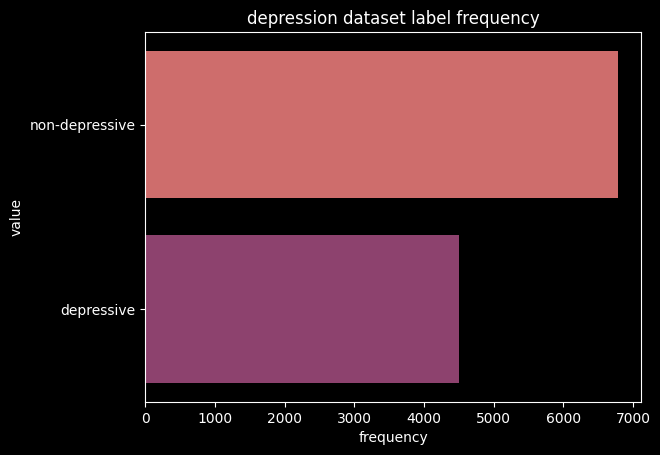

In [23]:
view_label_freq(ddr['label'].value_counts(),
    img_title='depression dataset label frequency', 
    save_img=False, 
    labels=["non-depressive", "depressive"])

# Pre-feature engineering
describes the task of engineering features at its raw form without yet preprocessing 

here we read the parquet file we wrote to a bronze staging layer

In [59]:
ddr_obj = s3.get_object(Bucket=BUCKET_NAME, Key=os.path.join(BRONZE_FOLDER_NAME, BRONZE_OBJECT_NAME))

In [60]:
ddr = pd.read_parquet(BytesIO(ddr_obj['Body'].read()))
ddr

text  label
0      He said he had not felt that way before, sugge...      0
1      Hey there r/assistance, Not sure if this is th...      0
2      My mom then hit me with the newspaper and it s...      0
3      until i met my new boyfriend, he is amazing, h...      0
4      October is Domestic Violence Awareness Month a...      1
...                                                  ...    ...
11279                                       is that snow      0
11280                 moulin rouge mad me cry once again      0
11281  trying to shout but can t find people on the list      0
11282  ughh can t find my red sox hat got ta wear thi...      0
11283  slept wonderfully finally tried swatching for ...      0

[11284 rows x 2 columns]

In [61]:
ddr['n_capital_chars'] = ddr['text'].apply(count_capital_chars)
ddr['n_capital_words'] = ddr['text'].apply(count_capital_words)
ddr['n_sents'] = ddr['text'].apply(count_sent)
ddr['n_stopwords'] = ddr['text'].apply(count_stopwords)

In [62]:
ddr

text  label  \
0      He said he had not felt that way before, sugge...      0   
1      Hey there r/assistance, Not sure if this is th...      0   
2      My mom then hit me with the newspaper and it s...      0   
3      until i met my new boyfriend, he is amazing, h...      0   
4      October is Domestic Violence Awareness Month a...      1   
...                                                  ...    ...   
11279                                       is that snow      0   
11280                 moulin rouge mad me cry once again      0   
11281  trying to shout but can t find people on the list      0   
11282  ughh can t find my red sox hat got ta wear thi...      0   
11283  slept wonderfully finally tried swatching for ...      0   

       n_capital_chars  n_capital_words  n_sents  n_stopwords  
0                   48               13        4           45  
1                   22                4        3           42  
2                   11                6        5           82  
3                   12                4        4          147  
4                   13                5        5           36  
...                ...              ...      ...          ...  
11279                0                0        1            2  
11280                0                0        1            3  
11281                0                0        1            6  
11282                0                0        1            4  
11283                0                0        1            7  

[11284 rows x 6 columns]

In [63]:
n_puncts_df = pd.DataFrame.from_records(ddr['text'].apply(count_punctuations).to_list())
n_puncts_df

!_punct_count  \_punct_count  "_punct_count  #_punct_count  \
0                  0              0              6              0   
1                  0              0              0              0   
2                  0              0              4              0   
3                  0              0              4              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
11279              0              0              0              0   
11280              0              0              0              0   
11281              0              0              0              0   
11282              0              0              0              0   
11283              0              0              0              0   

       $_punct_count  %_punct_count  &_punct_count  '_punct_count  \
0                  0              0              0              2   
1                  1              0              0              3   
2                  0              0              0              2   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
11279              0              0              0              0   
11280              0              0              0              0   
11281              0              0              0              0   
11282              0              0              0              0   
11283              0              0              0              0   

       (_punct_count  )_punct_count  ...  @_punct_count  [_punct_count  \
0                  0              0  ...              0              0   
1                  0              1  ...              0              0   
2                  0              0  ...              0              0   
3                  1              1  ...              0              0   
4                  1              1  ...              0              0   
...              ...            ...  ...            ...            ...   
11279              0              0  ...              0              0   
11280              0              0  ...              0              0   
11281              0              0  ...              0              0   
11282              0              0  ...              0              0   
11283              0              0  ...              0              0   

       ]_punct_count  ^_punct_count  __punct_count  `_punct_count  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
11279              0              0              0              0   
11280              0              0              0              0   
11281              0              0              0              0   
11282              0              0              0              0   
11283              0              0              0              0   

       {_punct_count  |_punct_count  }_punct_count  ~_punct_count  
0                  0              0              0              0  
1                  0              0              0              0  
2                  0              0              0              0  
3                  0              0              0              0  
4                  0              0              0              0  
...              ...            ...            ...            ...  
11279              0              0              0              0  
11280              0              0              0              0  
11281              

In [64]:
ddr = pd.concat([ddr, n_puncts_df], axis=1)
ddr

text  label  \
0      He said he had not felt that way before, sugge...      0   
1      Hey there r/assistance, Not sure if this is th...      0   
2      My mom then hit me with the newspaper and it s...      0   
3      until i met my new boyfriend, he is amazing, h...      0   
4      October is Domestic Violence Awareness Month a...      1   
...                                                  ...    ...   
11279                                       is that snow      0   
11280                 moulin rouge mad me cry once again      0   
11281  trying to shout but can t find people on the list      0   
11282  ughh can t find my red sox hat got ta wear thi...      0   
11283  slept wonderfully finally tried swatching for ...      0   

       n_capital_chars  n_capital_words  n_sents  n_stopwords  !_punct_count  \
0                   48               13        4           45              0   
1                   22                4        3           42              0   
2                   11                6        5           82              0   
3                   12                4        4          147              0   
4                   13                5        5           36              0   
...                ...              ...      ...          ...            ...   
11279                0                0        1            2              0   
11280                0                0        1            3              0   
11281                0                0        1            6              0   
11282                0                0        1            4              0   
11283                0                0        1            7              0   

       \_punct_count  "_punct_count  #_punct_count  ...  @_punct_count  \
0                  0              6              0  ...              0   
1                  0              0              0  ...              0   
2                  0              4              0  ...              0   
3                  0              4              0  ...              0   
4                  0              0              0  ...              0   
...              ...            ...            ...  ...            ...   
11279              0              0              0  ...              0   
11280              0              0              0  ...              0   
11281              0              0              0  ...              0   
11282              0              0              0  ...              0   
11283              0              0              0  ...              0   

       [_punct_count  ]_punct_count  ^_punct_count  __punct_count  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
11279              0              0              0              0   
11280              0              0              0              0   
11281              0              0              0              0   
11282              0              0              0              0   
11283              0              0              0              0   

       `_punct_count  {_punct_count  |_punct_count  }_punct_count  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
11279              0              0              0              0   
11280           

In [65]:
ddr["text"]

0        He said he had not felt that way before, sugge...
1        Hey there r/assistance, Not sure if this is th...
2        My mom then hit me with the newspaper and it s...
3        until i met my new boyfriend, he is amazing, h...
4        October is Domestic Violence Awareness Month a...
                               ...                        
11279                                         is that snow
11280                   moulin rouge mad me cry once again
11281    trying to shout but can t find people on the list
11282    ughh can t find my red sox hat got ta wear thi...
11283    slept wonderfully finally tried swatching for ...
Name: text, Length: 11284, dtype: object

# Preprocessing 
- turning words into lowercase
- Removing contractions e.g. `"didn't"` -> `"did not"`, `"couldn't"` -> `"could not"`
- removing non alpha numeric characters e.g. `"#&@somehastag"` -> `"somehastag"`
- turns the unstemmed version of a word i.e. playing to its stemmed version play
- breaks down a word into its root form, or lemma, to analyze it as a single item e.g. changing, changed, base form is change
- remove trailing and leading whitespaces in each row e.g. `"   hello world   "` -> `"hello world"`

In [66]:
ddr['text'] = ddr['text'].apply(lower_words)
ddr['text'] = ddr['text'].apply(remove_contractions)
ddr['text'] = ddr['text'].apply(rem_non_alpha_num)
ddr['text'] = ddr['text'].apply(stem_corpus_words)
ddr['text'] = ddr['text'].apply(lemmatize_corpus_words)
ddr['text'] = ddr['text'].apply(strip_final_corpus)

he said he had not felt that way before, suggeted i go rest and so ..trigger ahead if youi are  a hypocondriac like me: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something i could even laugh at down the road. no, i ended up reading that this sense of doom can be indicative of various health ailments; one of which i am prone to.. so on top of my "doom" to my gloom..i am now f'n worried about my heart. i do happen to have a physical in 48 hours.
hey there r/assistance, not sure if this is the right place to post this.. but here goes =) i am  currently a student intern at sandia national labs and working on a survey to help improve our marketing outreach efforts at the many schools we recruit at around the country. we are  looking for current undergrad/grad stem students so if you are  a stem student or know stem students, i would greatly appreciate if you can help

# Post-feature engineering

In [67]:
ddr['n_chars'] = ddr['text'].apply(count_chars)
ddr['n_words'] = ddr['text'].apply(count_words)
ddr['n_unique_words'] = ddr['text'].apply(count_unique_words)

# split into train, val, and test

In [68]:
ddr_ndep = ddr[ddr["label"] == 0]
ddr_ndep.head()

text  label  n_capital_chars  \
0  he said he had not felt that way before sugget...      0               48   
1  hey there r assist not sure if this is the rig...      0               22   
2  my mom then hit me with the newspap and it sho...      0               11   
3  until i met my new boyfriend he is amaz he is ...      0               12   
5  i think he doe not want to put in the effort f...      0               16   

   n_capital_words  n_sents  n_stopwords  !_punct_count  \_punct_count  \
0               13        4           45              0              0   
1                4        3           42              0              0   
2                6        5           82              0              0   
3                4        4          147              0              0   
5                8        5           49              0              0   

   "_punct_count  #_punct_count  ...  ^_punct_count  __punct_count  \
0              6              0  ...              0              0   
1              0              0  ...              0              0   
2              4              0  ...              0              0   
3              4              0  ...              0              0   
5              0              0  ...              0              0   

   `_punct_count  {_punct_count  |_punct_count  }_punct_count  ~_punct_count  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
5              0              0              0              0              0   

   n_chars  n_words  n_unique_words  
0      528      115              92  
1      545      112              79  
2      776      168             100  
3     1190      273             114  
5      519      110              76  

[5 rows x 41 columns]

In [69]:
# we get the labels that have depressive labels
ddr_dep = ddr[ddr["label"] == 1]
ddr_dep.head()

text  label  n_capital_chars  \
4   octob is domest violenc awar month and i am a ...      1               13   
7   it clear up and i wa okay but. on monday i wa ...      1               17   
8   i actual give an assist half my emerg fee to c...      1                8   
12  i ve been take 12.5 mg zoloft for about 6 mont...      1               11   
15  i ask him three time what happened. and after ...      1                8   

    n_capital_words  n_sents  n_stopwords  !_punct_count  \_punct_count  \
4                 5        5           36              0              0   
7                12        5           44              0              0   
8                 4        5           33              0              0   
12                2        5           40              0              0   
15                5        5           32              0              0   

    "_punct_count  #_punct_count  ...  ^_punct_count  __punct_count  \
4               0              0  ...              0              0   
7               0              0  ...              0              0   
8               2              0  ...              0              0   
12              0              0  ...              0              0   
15              0              0  ...              0              0   

    `_punct_count  {_punct_count  |_punct_count  }_punct_count  ~_punct_count  \
4               0              0              0              0              0   
7               0              0              0              0              0   
8               0              0              0              0              0   
12              0              0              0              0              0   
15              0              0              0              0              0   

    n_chars  n_words  n_unique_words  
4       452       90              71  
7       517      113              58  
8       401       81              61  
12      416       95              69  
15      358       79              45  

[5 rows x 41 columns]

In [70]:
ddr_dep.shape

(4507, 41)

In [71]:
ddr_ndep.shape

(6777, 41)

In [72]:
train_ddr_dep, ddr_dep_ = split_into_train_test(ddr_dep)
val_ddr_dep, test_ddr_dep = split_into_train_test(ddr_dep_, train_ratio=0.75)

In [73]:
train_ddr_dep.shape, val_ddr_dep.shape, test_ddr_dep.shape

((2929, 41), (1183, 41), (395, 41))

In [74]:
train_ddr_ndep, ddr_ndep_ = split_into_train_test(ddr_ndep)
val_ddr_ndep, test_ddr_ndep = split_into_train_test(ddr_ndep_, train_ratio=0.75)

In [75]:
train_ddr_ndep.shape, val_ddr_ndep.shape, test_ddr_ndep.shape

((4405, 41), (1779, 41), (593, 41))

# Recombine the datasets with non depressive and depressive according to their data split

In [105]:
train_ddr = pd.concat([train_ddr_dep, train_ddr_ndep]).reset_index(drop=True)
val_ddr = pd.concat([val_ddr_dep, val_ddr_ndep]).reset_index(drop=True)
test_ddr = pd.concat([test_ddr_dep, test_ddr_ndep]).reset_index(drop=True)
train_ddr.shape, val_ddr.shape, test_ddr.shape

<string>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?


((7334, 41), (2962, 41), (988, 41))

In [106]:
train_ddr

text  label  \
0     at this point i have move home live with 4 you...      1   
1     i wa pick up dinner and when i went to close t...      1   
2     friend just attempt to jump off a build approx...      1   
3     hi everyon i m go to tell about my thought i m...      1   
4     i am date her for more than one year now and e...      1   
...                                                 ...    ...   
7329  kenichan i dive mani time for the ball manag t...      0   
7330  well i guess it wa my second. last week we set...      0   
7331            misterphipp you cook risotto without me      0   
7332  so here s he thing. i do have feel for him. th...      0   
7333  specificphobia most commom type. it is when so...      0   

      n_capital_chars  n_capital_words  n_sents  n_stopwords  !_punct_count  \
0                  17                8        5           40              0   
1                   0                0        1           34              0   
2                   0                0        1           42              0   
3                   0                0        1           83              0   
4                   9                4        5           25              0   
...               ...              ...      ...          ...            ...   
7329                0                0        1            7              0   
7330                6                2        5           31              0   
7331                0                0        1            2              0   
7332                8                3        5           17              0   
7333                9                2        4           10              0   

      \_punct_count  "_punct_count  #_punct_count  ...  ^_punct_count  \
0                 0              0              0  ...              0   
1                 0              0              0  ...              0   
2                 0              0              0  ...              0   
3                 0              0              0  ...              0   
4                 0              0              0  ...              0   
...             ...            ...            ...  ...            ...   
7329              0              0              0  ...              0   
7330              0              0              0  ...              0   
7331              0              0              0  ...              0   
7332              0              0              0  ...              0   
7333              0              0              0  ...              0   

      __punct_count  `_punct_count  {_punct_count  |_punct_count  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
7329              0              0              0              0   
7330              0              0              0              0   
7331              0              0              0              0   
7332              0              0              0              0   
7333              0              0              0              0   

      }_punct_count  ~_punct_count  n_chars  n_words  n_unique_words  
0                 0              0      515      106              74  
1                 0              0      231       56              38  
2                 0              0      335       76              64  
3                 0              0      647      146              90  
4                 0              0      305       68              54  
...             ...            ...      ...      ...             ...  
7329              0              0       79       18              17  
7330              0              0      345    

In [107]:
train_ddr["text"]

0       at this point i have move home live with 4 you...
1       i wa pick up dinner and when i went to close t...
2       friend just attempt to jump off a build approx...
3       hi everyon i m go to tell about my thought i m...
4       i am date her for more than one year now and e...
                              ...                        
7329    kenichan i dive mani time for the ball manag t...
7330    well i guess it wa my second. last week we set...
7331              misterphipp you cook risotto without me
7332    so here s he thing. i do have feel for him. th...
7333    specificphobia most commom type. it is when so...
Name: text, Length: 7334, dtype: object

# create tfidf features using `TfidfVectorizer`

In [108]:
train_vec, val_vec, test_vec, vectorizer = vectorize_sent(train_ddr["text"], val_ddr["text"], test_ddr["text"])
train_vec.shape, val_vec.shape, test_vec.shape

((7334, 15385), (2962, 15385), (988, 15385))

In [109]:
train_vec

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.20598478, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(7334, 15385))

In [110]:
train_vec = pd.DataFrame(train_vec, columns=[f"tf_idf_{i + 1}" for i in range(train_vec.shape[1])])
val_vec = pd.DataFrame(val_vec, columns=[f"tf_idf_{i + 1}" for i in range(val_vec.shape[1])])
test_vec = pd.DataFrame(test_vec, columns=[f"tf_idf_{i + 1}" for i in range(test_vec.shape[1])])

In [111]:
train_vec

tf_idf_1  tf_idf_2  tf_idf_3  tf_idf_4  tf_idf_5  tf_idf_6  tf_idf_7  \
0     0.000000       0.0       0.0       0.0       0.0       0.0       0.0   
1     0.205985       0.0       0.0       0.0       0.0       0.0       0.0   
2     0.000000       0.0       0.0       0.0       0.0       0.0       0.0   
3     0.000000       0.0       0.0       0.0       0.0       0.0       0.0   
4     0.000000       0.0       0.0       0.0       0.0       0.0       0.0   
...        ...       ...       ...       ...       ...       ...       ...   
7329  0.000000       0.0       0.0       0.0       0.0       0.0       0.0   
7330  0.000000       0.0       0.0       0.0       0.0       0.0       0.0   
7331  0.000000       0.0       0.0       0.0       0.0       0.0       0.0   
7332  0.000000       0.0       0.0       0.0       0.0       0.0       0.0   
7333  0.000000       0.0       0.0       0.0       0.0       0.0       0.0   

      tf_idf_8  tf_idf_9  tf_idf_10  ...  tf_idf_15376  tf_idf_15377  \
0          0.0       0.0        0.0  ...           0.0           0.0   
1          0.0       0.0        0.0  ...           0.0           0.0   
2          0.0       0.0        0.0  ...           0.0           0.0   
3          0.0       0.0        0.0  ...           0.0           0.0   
4          0.0       0.0        0.0  ...           0.0           0.0   
...        ...       ...        ...  ...           ...           ...   
7329       0.0       0.0        0.0  ...           0.0           0.0   
7330       0.0       0.0        0.0  ...           0.0           0.0   
7331       0.0       0.0        0.0  ...           0.0           0.0   
7332       0.0       0.0        0.0  ...           0.0           0.0   
7333       0.0       0.0        0.0  ...           0.0           0.0   

      tf_idf_15378  tf_idf_15379  tf_idf_15380  tf_idf_15381  tf_idf_15382  \
0              0.0           0.0           0.0           0.0           0.0   
1              0.0           0.0           0.0           0.0           0.0   
2              0.0           0.0           0.0           0.0           0.0   
3              0.0           0.0           0.0           0.0           0.0   
4              0.0           0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...           ...   
7329           0.0           0.0           0.0           0.0           0.0   
7330           0.0           0.0           0.0           0.0           0.0   
7331           0.0           0.0           0.0           0.0           0.0   
7332           0.0           0.0           0.0           0.0           0.0   
7333           0.0           0.0           0.0           0.0           0.0   

      tf_idf_15383  tf_idf_15384  tf_idf_15385  
0              0.0           0.0           0.0  
1              0.0           0.0           0.0  
2              0.0           0.0           0.0  
3              0.0           0.0           0.0  
4              0.0           0.0           0.0  
...            ...           ...           ...  
7329           0.0           0.0           0.0  
7330           0.0           0.0           0.0  
7331           0.0           0.0           0.0  
7332           0.0           0.0           0.0  
7333           0.0           0.0           0.0  

[7334 rows x 15385 columns]

In [112]:
cols_to_use = train_ddr.columns[train_ddr.columns != "text"]
cols_to_use

Index(['label', 'n_capital_chars', 'n_capital_words', 'n_sents', 'n_stopwords',
       '!_punct_count', '\_punct_count', '"_punct_count', '#_punct_count',
       '$_punct_count', '%_punct_count', '&_punct_count', ''_punct_count',
       '(_punct_count', ')_punct_count', '*_punct_count', '+_punct_count',
       ',_punct_count', '-_punct_count', '._punct_count', '/_punct_count',
       ':_punct_count', ';_punct_count', '<_punct_count', '=_punct_count',
       '>_punct_count', '?_punct_count', '@_punct_count', '[_punct_count',
       ']_punct_count', '^_punct_count', '__punct_count', '`_punct_count',
       '{_punct_count', '|_punct_count', '}_punct_count', '~_punct_count',
       'n_chars', 'n_words', 'n_unique_words'],
      dtype='object')

In [113]:
train_data = pd.concat([train_ddr[cols_to_use], train_vec], axis=1)
val_data = pd.concat([val_ddr[cols_to_use], val_vec], axis=1)
test_data = pd.concat([test_ddr[cols_to_use], test_vec], axis=1)
train_data.shape, val_data.shape, test_data.shape

((7334, 15425), (2962, 15425), (988, 15425))

In [114]:
train_data

label  n_capital_chars  n_capital_words  n_sents  n_stopwords  \
0         1               17                8        5           40   
1         1                0                0        1           34   
2         1                0                0        1           42   
3         1                0                0        1           83   
4         1                9                4        5           25   
...     ...              ...              ...      ...          ...   
7329      0                0                0        1            7   
7330      0                6                2        5           31   
7331      0                0                0        1            2   
7332      0                8                3        5           17   
7333      0                9                2        4           10   

      !_punct_count  \_punct_count  "_punct_count  #_punct_count  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
7329              0              0              0              0   
7330              0              0              0              0   
7331              0              0              0              0   
7332              0              0              0              0   
7333              0              0              0              0   

      $_punct_count  ...  tf_idf_15376  tf_idf_15377  tf_idf_15378  \
0                 0  ...           0.0           0.0           0.0   
1                 0  ...           0.0           0.0           0.0   
2                 0  ...           0.0           0.0           0.0   
3                 0  ...           0.0           0.0           0.0   
4                 0  ...           0.0           0.0           0.0   
...             ...  ...           ...           ...           ...   
7329              0  ...           0.0           0.0           0.0   
7330              0  ...           0.0           0.0           0.0   
7331              0  ...           0.0           0.0           0.0   
7332              0  ...           0.0           0.0           0.0   
7333              0  ...           0.0           0.0           0.0   

      tf_idf_15379  tf_idf_15380  tf_idf_15381  tf_idf_15382  tf_idf_15383  \
0              0.0           0.0           0.0           0.0           0.0   
1              0.0           0.0           0.0           0.0           0.0   
2              0.0           0.0           0.0           0.0           0.0   
3              0.0           0.0           0.0           0.0           0.0   
4              0.0           0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...           ...   
7329           0.0           0.0           0.0           0.0           0.0   
7330           0.0           0.0           0.0           0.0           0.0   
7331           0.0           0.0           0.0           0.0           0.0   
7332           0.0           0.0           0.0           0.0           0.0   
7333           0.0           0.0           0.0           0.0           0.0   

      tf_idf_15384  tf_idf_15385  
0              0.0           0.0  
1              0.0           0.0  
2              0.0           0.0  
3              0.0           0.0  
4              0.0           0.0  
...            ...           ...  
7329           0.0           0.0  
7330           0.0           0.0  
7331           0.0           0.0  
7332           0.0           0.0  
7333           0.0           0.0  

[7334 rows x 15425 columns]

# Data normalization

In [115]:
X_cols = train_data.columns[train_data.columns != "label"]
Y_cols = train_data.columns[train_data.columns == "label"]
X_cols, Y_cols

(Index(['n_capital_chars', 'n_capital_words', 'n_sents', 'n_stopwords',
        '!_punct_count', '\_punct_count', '"_punct_count', '#_punct_count',
        '$_punct_count', '%_punct_count',
        ...
        'tf_idf_15376', 'tf_idf_15377', 'tf_idf_15378', 'tf_idf_15379',
        'tf_idf_15380', 'tf_idf_15381', 'tf_idf_15382', 'tf_idf_15383',
        'tf_idf_15384', 'tf_idf_15385'],
       dtype='object', length=15424),
 Index(['label'], dtype='object'))

In [118]:
# remove subject_id column then convert to numpy array
train_input_normed, val_input_normed, test_input_normed, normalizer = normalize_train_cross(
    train_data[X_cols],
    val_data[X_cols],
    test_data[X_cols],
    scaler="min_max",
)
train_input_normed.shape, val_input_normed.shape, test_input_normed.shape

((7334, 15424), (2962, 15424), (988, 15424))

In [119]:
train_input_normed

n_capital_chars  n_capital_words  n_sents  n_stopwords  !_punct_count  \
0            0.137097             0.32      0.8     0.016708            0.0   
1            0.000000             0.00      0.0     0.014202            0.0   
2            0.000000             0.00      0.0     0.017544            0.0   
3            0.000000             0.00      0.0     0.034670            0.0   
4            0.072581             0.16      0.8     0.010443            0.0   
...               ...              ...      ...          ...            ...   
7329         0.000000             0.00      0.0     0.002924            0.0   
7330         0.048387             0.08      0.8     0.012949            0.0   
7331         0.000000             0.00      0.0     0.000835            0.0   
7332         0.064516             0.12      0.8     0.007101            0.0   
7333         0.072581             0.08      0.6     0.004177            0.0   

      \_punct_count  "_punct_count  #_punct_count  $_punct_count  \
0               0.0            0.0            0.0            0.0   
1               0.0            0.0            0.0            0.0   
2               0.0            0.0            0.0            0.0   
3               0.0            0.0            0.0            0.0   
4               0.0            0.0            0.0            0.0   
...             ...            ...            ...            ...   
7329            0.0            0.0            0.0            0.0   
7330            0.0            0.0            0.0            0.0   
7331            0.0            0.0            0.0            0.0   
7332            0.0            0.0            0.0            0.0   
7333            0.0            0.0            0.0            0.0   

      %_punct_count  ...  tf_idf_15376  tf_idf_15377  tf_idf_15378  \
0               0.0  ...           0.0           0.0           0.0   
1               0.0  ...           0.0           0.0           0.0   
2               0.0  ...           0.0           0.0           0.0   
3               0.0  ...           0.0           0.0           0.0   
4               0.0  ...           0.0           0.0           0.0   
...             ...  ...           ...           ...           ...   
7329            0.0  ...           0.0           0.0           0.0   
7330            0.0  ...           0.0           0.0           0.0   
7331            0.0  ...           0.0           0.0           0.0   
7332            0.0  ...           0.0           0.0           0.0   
7333            0.0  ...           0.0           0.0           0.0   

      tf_idf_15379  tf_idf_15380  tf_idf_15381  tf_idf_15382  tf_idf_15383  \
0              0.0           0.0           0.0           0.0           0.0   
1              0.0           0.0           0.0           0.0           0.0   
2              0.0           0.0           0.0           0.0           0.0   
3              0.0           0.0           0.0           0.0           0.0   
4              0.0           0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...           ...   
7329           0.0           0.0           0.0           0.0           0.0   
7330           0.0           0.0           0.0           0.0           0.0   
7331           0.0           0.0           0.0           0.0           0.0   
7332           0.0           0.0           0.0           0.0           0.0   
7333           0.0           0.0           0.0           0.0           0.0   

      tf_idf_15384  tf_idf_15385  
0              0.0           0.0  
1              0.0           0.0  
2              0.0           0.0  
3              0.0           0.0  
4              0.0           0.0  
...            ...           ...  
7329           0.0           0.0  
7330           0.0           0.0  
7331           0.0           0.0  
7332           0.0           0.0  
7333           0.0           0.0  

[7334 rows x 15424 columns]

In [122]:
train_output = train_data[Y_cols]
val_output = val_data[Y_cols]
test_output = test_data[Y_cols]
train_output.shape, val_output.shape, test_output.shape

((7334, 1), (2962, 1), (988, 1))

In [123]:
train_output[:10]

label
0      1
1      1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1

# Save each split to silver staging layer

In [126]:
SILVER_FOLDER_NAME = "ddr-data-silver/"
SILVER_OBJECTS_AND_NAMES = [
    (train_input_normed, "train_input_normed.parquet"), 
    (val_input_normed, "val_input_normed.parquet"), 
    (test_input_normed, "test_input_normed.parquet"), 
    (train_output, "train_output.parquet"), 
    (val_output, "val_output.parquet"), 
    (test_output, "test_output.parquet")
]

In [127]:
for SILVER_OBJECT, SILVER_OBJECT_NAME in SILVER_OBJECTS_AND_NAMES:
    write_parq_df_to_bucket(s3, SILVER_OBJECT, BUCKET_NAME, SILVER_FOLDER_NAME, SILVER_OBJECT_NAME)

In [128]:
def read_parq_df_from_s3(s3: boto3.client, bucket_name: str, folder_name: str, object_name: str):
    df_obj = s3.get_object(Bucket=bucket_name, Key=os.path.join(folder_name, object_name))
    df = pd.read_parquet(BytesIO(df_obj['Body'].read()))

    return df

In [129]:
train_input_normed, val_input_normed, test_input_normed, train_output, val_output, test_output = [
    read_parq_df_from_s3(s3, BUCKET_NAME, SILVER_FOLDER_NAME, SILVER_OBJECT_NAME) 
    for _, SILVER_OBJECT_NAME in SILVER_OBJECTS_AND_NAMES
]

In [130]:
train_input_normed.shape, val_input_normed.shape, test_input_normed.shape, train_output.shape, val_output.shape, test_output.shape

((7334, 15424), (2962, 15424), (988, 15424), (7334, 1), (2962, 1), (988, 1))

# Now that features have been engineered we need to do feature selection

In [131]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.utils.class_weight import compute_class_weight

In [132]:
n_features = 50

In [133]:
# select best features first by means of backward
# feature selection based on support vector classifiers
model = RandomForestClassifier(verbose=1)
selector = RFE(estimator=model, n_features_to_select=n_features, verbose=1)

# train feature selector on data
selector.fit(train_input_normed, train_output)

# obtain feature mask boolean values, and use it as index
# to select only the columns that have been selected by BFS 
feats_mask = selector.get_support().tolist()

Fitting estimator with 15424 features.


c:\Users\LARRY\anaconda3\envs\tech-interview\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   16.8s


AttributeError: 'Parallel' object has no attribute '_pre_dispatch_amount'

In [ ]:
X_cols = train_data.columns[train_data.columns != "label"]